In [2]:
import os
import time

import geoutils as gu
import numpy as np
import pyperclip as pc

from itertools import product
from dataclasses import dataclass
from matplotlib import pyplot as plt
from IPython.display import clear_output
from scipy.ndimage import convolve
from scipy.ndimage.measurements import label
from PIL import Image

np.set_printoptions(linewidth=200)

In [94]:
fns = [fn for fn in os.listdir("data") if fn.endswith(".tif")]
rasters = sorted([gu.Raster(os.path.join("data", fn)) for fn in fns], key=lambda r: r.bounds[:2])

raster = rasters[0]
print(raster)

Driver:               GTiff 
Opened from file:     C:\Users\david\Desktop\heightmap\data\swissalti3d_2021_2532-1151_0.5_2056_5728.tif 
Filename:             data\swissalti3d_2021_2532-1151_0.5_2056_5728.tif 
Raster modified since disk load?  False 
Size:                 2000, 2000
Number of bands:      1
Data types:           ('float32',)
Coordinate System:    EPSG:2056
NoData Value:         -9999.0
Pixel Size:           0.5, 0.5
Upper Left Corner:    2532000.0, 1151000.0
Lower Right Corner:   2533000.0, 1152000.0



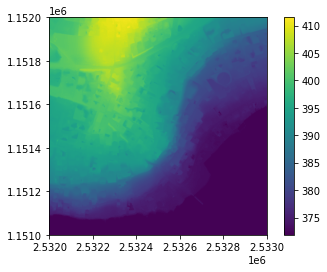

In [95]:
raster.show()

In [9]:
minX = -1472
minZ = -1216

In [10]:
nMapsX = 25
nMapsZ = 17

In [13]:
def mapTopLeft(mX, mZ):
    return mX * 128 - 64, mZ * 128 - 64

In [15]:
def position(xC, zC):
    z0 = -135.5
    x0 = 79.5
    fac = 1
    hCoeff = 1.34903905766

    longitude = 3470
    latitude = 2562.5
 
    mZ = 1.029661
    hX = 2540000
    hZ = 1150000 + 4.741

    resX = - x0 - hCoeff * (longitude - xC) + hX
    resZ = mZ * (z0 + hCoeff * (latitude - zC)) + hZ

    return resX, resZ

def mc2topo(tuples):
    return [position(*t) for t in tuples]

def find_raster(x, z, rasters, old=None):
    full_rasters = rasters
    
    if old is not None:
        full_rasters = [old,] + full_rasters
    
    for r in full_rasters:
        left, bottom, right, top = tuple(r.bounds)
        
        if x >= left and z >= bottom and x < right and z < top:
            return r
        
    raise Exception(f"No raster was found for x = {x} and z = {z}")

def topo2hm(tuples, rasters):
    r = None
    res = []
    
    for x, z in tuples:
        r = find_raster(x, z, rasters, r)
        res.append((x, r.value_at_coords(x, z), z))
        
    return res

def hm2cmd(mc_tuples, hm_tuples, strings, block, vShift=0):
    ret = []
    
    for (mcX, mcZ), (x, y, z) in zip(mc_tuples, hm_tuples):
        cmd = strings["command"].format(mcX, round(y + vShift), mcZ, block)
        cmd = strings["template"].format(cmd)
        
        ret.append(cmd)
        
    return ret

In [17]:
def paint_area(x, z, rasters, strings, block, vShift=0, radius=10, circle=False):
    span = np.array(range(-radius, radius + 1))
    mc_tuples = list(product(span + x, span + z))
    
    if circle:
        mc_tuples = [t for t in mc_tuples if (t[0] - x) ** 2 + (t[1] - z) ** 2 <= radius ** 2]
        
    topo_tuples = mc2topo(mc_tuples)
    hm_tuples = topo2hm(topo_tuples, rasters)
    cmds = hm2cmd(mc_tuples, hm_tuples, strings, block, vShift)
    
    return cmds

In [20]:
cmds = paint_area(20, 0, rasters, strings, "gold_block", vShift=-400)

In [21]:
package_commands(cmds, strings)

Batch 1 of 1


In [41]:
def assign(array, value, xS, zS, w, h):
    res = array.copy()
    res[zS:zS + h, xS:xS + w] = value
    return res

In [82]:
arr = np.zeros((7, 5), dtype=bool)
arr = assign(arr, True, 2, 2, 2, 3)
arr = assign(arr, False, 3, 3, 1, 1)
arr.shape

(7, 5)

# JUNKYARD

In [232]:
base = np.ones(tsrct.shape)
trans = np.transpose(base, axes=[0, 2, 1, 3])
cut = np.tril(trans[::, ::-1, ::, ::])[::, ::, ::-1, ::]
detrans = np.transpose(cut, axes=[3, 1, 2, 0])
#show_tsrct(detrans)

In [231]:
base = np.ones(tsrct.shape)
trans = np.transpose(base, axes=[2, 0, 3, 1])
cut = np.triu(trans[::-1, ::, ::, ::])[::, ::, ::, ::-1]
detrans = np.transpose(cut, axes=[1, 3, 0, 2])
#show_tsrct(detrans)

In [226]:
# This was very cool to code but utterly useless

def update_shifts(sub_arr, pos):
    sub_arr[:, 1] = -np.clip(sub_arr[:, 1] + 2 - pos, 0, 2) + 2
            
def set_block_at_opt(tsrct, i0, j0, val):
    h, w = tsrct.shape[:2]
    
    if i0 >= h or j0 >= w:
        raise Exception("Indices do not fit the tesseract!")

    arrX = np.column_stack(np.tril_indices(h))
    arrY = np.column_stack(np.tril_indices(w))
    
    update_shifts(arrX, i)
    update_shifts(arrY, j)
    
    coordinates = [np.concatenate((x, y))[[0, 2, 1, 3]] for x, y in product(arrX, arrY)]
    mask = np.zeros(tsrct.shape)
    mask[tuple([np.array(elem) for elem in np.column_stack(coordinates)])] = 1
        
    if val:
        return np.logical_or(tsrct, mask)
    else:
        return np.logical_and(tsrct, 1 - mask)

def get_block_scores(tsrct):
    h, w = tsrct.shape[:2]
    ret = np.zeros((h, w))
    
    for i in range(h):
        for j in range(w):
            for iS in range(i + 1):
                for jS in range(j + 1):
                    ret += np.roll(tsrct[i, j], [iS, jS], axis=(0, 1))
    
    return ret

def get_block_scores_opt2(tsrct):
    h, w = tsrct.shape[:2]
    mem = get_block_scores_opt_subroutine2(tsrct.astype(np.int16), h)
    return get_block_scores_opt_subroutine2(mem, w)
            
def gen_tesseract(arr):
    h, w = arr.shape
    ret = np.zeros((h, w, h, w), dtype=bool)
    on_edge = np.zeros(ret.shape, dtype=bool)
    border = gen_border(arr)
    
    for i, j in np.column_stack(border.nonzero()):
        set_block_at(ret, i, j, True)
        
    for i, j in np.column_stack((1 - arr).nonzero()):
        set_block_at(ret, i, j, False)
            
    return ret
            
def gen_tesseract2(arr):
    h, w = arr.shape
    ret = np.zeros((h, w, h, w), dtype=bool)
    border = gen_border(arr)
    bound_mask = gen_bound_mask(arr)
    
    for i, j in np.column_stack(border.nonzero()):
        set_block_at(ret, i, j, True)
        
    return ret * (1 - bound_mask)

def gen_bound_mask_opt(arr, mask):
    h, w = arr.shape
    ret = np.zeros((h, w, h, w), dtype=bool)
    
    for i, j in np.column_stack((1 - arr).nonzero()):
        set_block_at_opt(ret, i, j, mask)
        
    return ret
            
def gen_tesseract3(arr):
    h, w = arr.shape
    ret = np.zeros((h, w, h, w), dtype=bool)
    border = gen_border(arr)
    mask = gen_mask(ret)
    bound_mask = gen_bound_mask_opt(arr, mask)
    
    for i, j in np.column_stack(border.nonzero()):
        set_block_at_opt(ret, i, j, mask)
        
    return ret * (1 - bound_mask)
            
def gen_tesseract4(arr):
    h, w = arr.shape
    ret = np.zeros((h, w, h, w), dtype=bool)
    border = gen_border(arr)
    mask = gen_mask(ret)
    bound_mask = gen_bound_mask_opt(arr, mask)
    
    for i, j in np.column_stack(border.nonzero()):
        set_block_at_opt_sub(ret, i, j, mask)
    
    return ret & mask & (1 - bound_mask)

def get_block_scores_opt_subroutine(tsrct, dim):
    proc = tsrct.copy()
        
    times = [time.time()]
    for i in range(dim):
        temp = proc[i]
        
        for iS in range(1, i + 1):
            temp += np.roll(tsrct[i], iS, axis=1)
        
        proc[i] = temp
        
        times.append(time.time())
        
    diff = [a-b for a, b in zip(times[1:], times[:-1])]
    print(dim, len(diff), np.sum(diff), np.mean(diff), np.std(diff))
        
    return np.sum(proc, axis=0)

# This is slower for some reason, even for large tesseracts
def get_block_scores_opt_subroutine2(tsrct, dim):
    proc = np.zeros(tsrct.shape, dtype=np.int16)
        
    times = [time.time()]
    for i in range(dim):
        proc[i:] += np.roll(tsrct[i:], i, axis=2)
        
        times.append(time.time())
        
    diff = [a-b for a, b in zip(times[1:], times[:-1])]
    print(dim, len(diff), np.sum(diff), np.mean(diff), np.std(diff))
        
    return np.sum(proc, axis=0)

def get_block_scores_opt_subroutine2_opt(tsrct, dim):
    proc = np.zeros(tsrct.shape, dtype=np.int16)
        
    times = [time.time()]
    for i in range(dim):
        proc[i:, :, i:] += tsrct[i:, :, :dim - i]
        
        times.append(time.time())
        
    diff = [a-b for a, b in zip(times[1:], times[:-1])]
    print(dim, len(diff), np.sum(diff), np.mean(diff), np.std(diff))
        
    return np.sum(proc, axis=0)

def gen_block_scores_opt_subroutine(tsrct, mask, dim):
    proc = np.zeros(tsrct.shape)
    
    for i in range(dim):
        proc[i:, :, i:] += tsrct[i:, :, :dim - i] * mask[i:, :, :dim - i]
        
    return np.sum(proc, axis=0)

def gen_block_scores_opt_subroutine_old(tsrct, dim):
    proc = tsrct.copy()
    
    for i in range(dim):
        temp = np.zeros(tsrct[i].shape)
        
        for iS in range(i + 1):
            temp[:, iS:dim - i + iS] += tsrct[i, :, :dim - i]
        
        proc[i] = temp
        
    return np.sum(proc, axis=0).astype(np.int16)

def get_block_scores_opt(tsrct):
    h, w = tsrct.shape[:2]
    mem = get_block_scores_opt_subroutine(tsrct.astype(np.int16), h)
    return get_block_scores_opt_subroutine(mem, w)

def get_block_scores_opt2(tsrct):
    h, w = tsrct.shape[:2]
    mem = get_block_scores_opt_subroutine2(tsrct.astype(np.int16), h)
    return get_block_scores_opt_subroutine2(mem, w)

def get_block_scores_opt2_opt(tsrct):
    h, w = tsrct.shape[:2]
    mem = get_block_scores_opt_subroutine2_opt(tsrct.astype(np.int16), h)
    return get_block_scores_opt_subroutine2_opt(mem, w)

def get_redundant_fills(scores, tsrct):
    h, w = tsrct.shape[:2]
    ret = np.zeros(tsrct.shape, dtype=bool)
    
    for i in range(h):
        for j in range(w):
            for iS in range(h - i):
                for jS in range(w - j):
                    if np.all(scores[i:i + iS + 1, j:j + jS + 1] > 1):
                        ret[iS, jS, i, j] = True
                        
    return ret

def remove_sub_fills(tsrct, scores, h, w, i, j):
    for h0, w0, i0, j0 in np.column_stack(tsrct.nonzero()):
        if h0 <= h and i <= i0 <= i + h - h0 and \
            w0 <= w and j <= j0 <= j + w - w0 and h0 + w0 < h + w:
            remove_fill_at(tsrct, scores, h0, w0, i0, j0)

# Using clever indexing instead of numpy.roll is about 4 times faster as no array is copied in the process
def gen_block_scores_opt_subroutine_old(tsrct, dim):
    print("Enter")
    proc = tsrct.copy()
    
    for i in range(dim):
        temp = proc[i]
        print("Dim")
        
        for iS in range(1, i + 1):
            temp[:, iS:] += tsrct[i, :, :dim - iS]
            
            new_shape = tsrct[i, :, :dim - iS].shape
        
        proc[i] = temp
        
    return np.sum(proc, axis=0).astype(np.int16)

In [27]:
def update_fills_wrong(fills, to_update, h0, w0, i0, j0):
    h, w = fills.shape[:2]
    
    for i1 in range(i0 + h0 + 1):
        for j1 in range(j0 + w0 + 1):
            for h1 in range(min(0, i0 - i1), h - i1):
                for w1 in range(min(0, j0 - j1), w - j1):
                    i2 = max(i1 - i0, 0)
                    j2 = max(j1 - j0, 0)
                    i3 = i1 - min(i0 + h0, i1 + h1)
                    j3 = j1 - min(j0 + w0, j1 + w1)
                    
                    if np.any(to_update[i2:i3 + 1, j2:j3 + 1]):
                        fills[h1, w1, i1, j1] = False

def finished(scores):
    return not np.any(scores > 1)
                    
def update_fill(tsrct, fills, i, j):
    h, w = tsrct.shape[:2]
    hUpper = max(i + 1, h - i)
    wUpper = max(j + 1, w - j)
    iUpper = min(h, i + 1)
    jUpper = min(w, j + 1)
    
    for h0, w0, i0, j0 in np.column_stack(tsrct.nonzero()):
        if h0 < hUpper and max(0, i - h0) <= i0 < iUpper and \
            w0 < wUpper and max(0, j - w0) <= j0 < jUpper:
            fills[h0, w0, i0, j0] = False
            return
            
def update_fill_opt_old(tsrct, fills, i, j):
    h, w = tsrct.shape[:2]
    mask = gen_tesseract_opt(np.ones((h, w)), carve=False)[:, :, h - i - 1:, w - j - 1:]
    temp = np.logical_not(tsrct[:, :, h - i - 1:, w - j - 1:] & mask)
    fills[:, :, :i + 1, :j + 1] = fills[:, :, :i + 1, :j + 1] & temp

def update_scores(scores, h, w, i, j):
    scores[i:i + h + 1, j:j + w + 1] -= 1
    return scores[i:i + h + 1, j:j + w + 1] == 1

def rm_next_redundant(tsrct, scores, fills):
    h, w = scores.shape[:2]
    
    for h0, w0, i, j in np.column_stack((tsrct * fills).nonzero()):
        tsrct[h0, w0, i, j] = False
        res = update_scores(scores, h0, w0, i, j)

        for i0, j0 in np.column_stack(res.nonzero()):
            update_fill(tsrct, fills, i + i0, j + j0)

        return True
    return False
    
def select_next_fill(tsrct, scores, fills):
    h, w = scores.shape[:2]
    
    for h0, w0, i, j in sorted(np.column_stack((tsrct * fills).nonzero()), key=lambda t: (-t[0], -t[1])):
    
        fills[h0, w0, i, j] = False
        remove_sub_fills_opt(tsrct, scores, h0, w0, i, j)
        
        for i0, j0 in np.column_stack((scores[i:i + h0 + 1, j:j + w0 + 1] == 1).nonzero()):
            update_fill_opt(tsrct, fills, i + i0, j + j0)

        return True
    return False

# VALID CODE

In [3]:
def set_block_at(tsrct, i0, j0, val):
    h, w = tsrct.shape[:2]
    
    if i0 >= h or j0 >= w:
        raise Exception("Indices do not fit the tesseract!")
        
    for h0 in range(h):
        for w0 in range(w):
            iLower, iUpper = max(0, i0 - h0), min(i0 + 1, h - h0)
            jLower, jUpper = max(0, j0 - w0), min(j0 + 1, w - w0)
            tsrct[h0, w0, iLower:iUpper, jLower:jUpper] = val
            
def set_block_at_opt(tsrct, i, j, mask):
    h, w = tsrct.shape[:2]
    pyrmd = mask[::-1, ::-1, i::-1, j::-1]
    tsrct[:, :, :i + 1, :j + 1] = (tsrct[:, :, :i + 1, :j + 1] | pyrmd) & mask[:, :, :i + 1, :j + 1]
            
def set_block_at_opt_sub(tsrct, i, j, mask):
    h, w = tsrct.shape[:2]
    pyrmd = mask[::-1, ::-1, i::-1, j::-1]
    sub_tsrct = tsrct[:, :, :i + 1, :j + 1]
    tsrct[:, :, :i + 1, :j + 1] = sub_tsrct | pyrmd
    
def gen_border(arr):
    h, w = arr.shape
    edge = np.ones((h, w), dtype=bool)
    edge[1:h-1,1:w-1] = 0
    
    dirs = [round(np.sin(i * np.pi / 2)) for i in range(4)]
    empties = arr == 0
    mem = empties.copy()
    
    for roll in zip(dirs, np.roll(dirs, -1)):
        mem += np.roll(empties, roll, axis=(0, 1))
        
    return (mem + edge) * (arr > 0)

def gen_bound_mask(arr):
    h, w = arr.shape
    ret = np.zeros((h, w, h, w), dtype=bool)
    
    for i, j in np.column_stack((1 - arr).nonzero()):
        set_block_at(ret, i, j, True)
        
    return ret

def gen_mask(tsrct):
    h, w = tsrct.shape[:2]
    mask = np.ones(tsrct.shape, dtype=bool)

    for i in range(h):
        mask[i, :, h - i:h, :] = 0

    for j in range(w):
        mask[:, j, :, w - j:w] = 0

    return mask

def gen_tesseract_opt_sub(arr, true_if_and):
    h, w = arr.shape
    ret = np.zeros((h, w, h, w), dtype=bool)
    ret[0, 0] = arr > 0

    for i in range(1, h):
        curr = ret[i - 1, 0]
        roll = np.roll(curr, -1, axis=0)
        roll[-1] = False
        ret[i, 0] = curr & roll if true_if_and else curr | roll

    for j in range(1, w):
        curr = ret[:, j - 1]
        roll = np.roll(curr, -1, axis=2)
        roll[:, :, -1] = False
        ret[:, j] = curr & roll if true_if_and else curr | roll
        
    return ret

def gen_tesseract_opt(arr, carve=True):
    border = gen_border(arr)
    ret = gen_tesseract_opt_sub(arr, True)
    
    if carve:
        no_fillers = gen_tesseract_opt_sub(border, False)
        ret = ret & no_fillers
    
    return ret

# Using clever indexing instead of numpy.roll is about 4 times faster as no array is copied in the process
def gen_block_scores_opt_subroutine(tsrct, dim):
    ret = np.zeros(tsrct.shape[1:])
    
    for i in range(dim):
        for iS in range(i + 1):
            ret[:, iS:dim - i + iS] += tsrct[i, :, :dim - i]
        
    return ret.astype(np.int16)

def gen_block_scores_opt(tsrct):
    h, w = tsrct.shape[:2]
    mem = gen_block_scores_opt_subroutine(tsrct, h)
    return gen_block_scores_opt_subroutine(mem, w)

# Generates a mask for all pixels that are not adjacent to 4 empty pixels/edges
def gen_not_lones(arr):
    kernel = [[0, 1, 0], [1, 5, 1], [0, 1, 0]]
    proc = np.pad(arr > 0, ((0, 1), (0, 1)), constant_values=0)
    proc = np.array(proc, dtype=np.int8)
    return 1 - (convolve(proc, kernel) == 5)[:-1, :-1]

def gen_redundant_fills_opt(tsrct, arr):
    fills = tsrct.copy()
    fills[0, 0] = tsrct[0, 0] # & gen_not_lones(arr) # This part can be ignored since the layer system deals with separate components already
    return fills

def yield_coords(tsrct, fills, gen):
    try:
        while True:
            h, w, i, j = next(gen)
            
            if tsrct[h, w, i, j] and fills[h, w, i, j]:
                return h, w, i, j
    except StopIteration:
        return None

def gen_coords_generator(tsrct):
    h, w = tsrct.shape[:2]
    order = sorted(np.column_stack(tsrct.nonzero()), key=lambda elem: (-max(elem[:2]), -elem[0], -elem[1]))
    
    for h0, w0, i0, j0 in order:
        yield h0, w0, i0, j0

In [4]:
def modify_fill_at(tsrct, scores, h, w, i, j, true_if_add):
    tsrct[h, w, i, j] = true_if_add
    scores[i:i + h + 1, j:j + w + 1] -= -1 if true_if_add else 1

def remove_fill_at(tsrct, scores, h, w, i, j):
    modify_fill_at(tsrct, scores, h, w, i, j, False)
    
def add_fill_at(tsrct, scores, h, w, i, j):
    modify_fill_at(tsrct, scores, h, w, i, j, True)

def remove_sub_fills_opt(tsrct, scores, h, w, i, j):
    sub_tsrct = tsrct[:h + 1, :w + 1, i:i + h + 1, j:j + w + 1]
    
    # Update scores
    full_scores = gen_block_scores_opt(sub_tsrct)
    self_scores = np.ones((h + 1, w + 1), dtype=np.int16)
    sub_scores = full_scores - self_scores
    scores[i:i + h + 1, j:j + w + 1] -= sub_scores
    
    # Update tesseract
    tsrct[:h + 1, :w + 1, i:i + h + 1, j:j + w + 1] = sub_tsrct & (1 - gen_tesseract_opt(sub_scores))
    tsrct[h, w, i, j] = True
        
# There seems to be a super tiny result difference between those two
def update_fill(tsrct, fills, i, j):
    h, w = tsrct.shape[:2]
    hUpper = max(i + 1, h - i)
    wUpper = max(j + 1, w - j)
    
    for h0, w0, i0, j0 in np.column_stack(tsrct.nonzero()):
        if h0 <= hUpper and max(0, i - h0) <= i0 < i + 1 and \
            w0 <= wUpper and max(0, j - w0) <= j0 < j + 1:
            fills[h0, w0, i0, j0] = False
            
def update_fill_opt(tsrct, fills, mask, hMax, wMax, i, j):
    h, w = tsrct.shape[:2]
    sub_mask = mask[:hMax, :wMax, h - i - 1:, w - j - 1:]
    temp = np.logical_not(tsrct[:hMax, :wMax, h - i - 1:, w - j - 1:] & sub_mask)
    fills[:hMax, :wMax, :i + 1, :j + 1] = fills[:hMax, :wMax, :i + 1, :j + 1] & temp

def select_next_fill_opt(tsrct, scores, fills, gen, mask, arr):
    h, w = scores.shape[:2]
    coords = yield_coords(tsrct, fills, gen)
    
    if coords is None:
        return False
    
    h0, w0, i, j = coords
    fills[h0, w0, i, j] = False
    remove_sub_fills_opt(tsrct, scores, h0, w0, i, j)
    
    for i0, j0 in np.column_stack(((scores[i:i + h0 + 1, j:j + w0 + 1] == 1) & (arr[i:i + h0 + 1, j:j + w0 + 1] == 1)).nonzero()):
        update_fill_opt(tsrct, fills, mask, h0 + 1, w0 + 1, i + i0, j + j0)
    
    return True

def sanitize(tsrct, scores):
    for h, w, i, j in sorted(np.column_stack(tsrct.nonzero()), key=lambda t: (-np.prod(t[:2]), -t[0])):
        if np.all(scores[i:i + h + 1, j:j + w + 1] > 1):
            remove_fill_at(tsrct, scores, h, w, i, j)
            
def shrink(tsrct, scores):
    for h, w, i, j in sorted(np.column_stack(tsrct.nonzero()), key=lambda t: (-np.prod(t[:2]), -t[0])):
        vals = scores[i:i + h + 1, j:j + w + 1] == 1
        aggrI = np.where(np.any(vals, axis=1))[0]
        aggrJ = np.where(np.any(vals, axis=0))[0]

        if len(aggrI) + len(aggrJ) > 0:
            iMin, iMax = aggrI[0], aggrI[-1]
            jMin, jMax = aggrJ[0], aggrJ[-1]
            newH = iMax - iMin
            newW = jMax - jMin

            if newH < h or newW < w:
                remove_fill_at(tsrct, scores, h, w, i, j)
                add_fill_at(tsrct, scores, newH, newW, i + iMin, j + jMin)

In [5]:
simple_str = "010110111"
simple_2_str = "001110111"
stairs_str = "1111111011101000"
star_str = "0010001110111110111000100"
hat_str = "0010001110111110001000000"
fish_str = "0000110000000110000100111100110111111010110111111001111110100011110011000110000100001100000000011000"
boat_str = "0000010000001111111000011111000001111100000111110000111111100000010000111111111101111111110011111110"
africa_str = """000011000000000001111110000000011111111110000011111111111000111111111111100111111111111110111111111111100011100111111100000000111111100000001111111000000001111110010000001111110010000000111110010000000111100000000000011000000"""
dk_str = """0000011111000000000000011111111000000000000101000110000000000011000001111100000000101010001111100000011010100011111100001100000001111111000010101000011111111000100000011011111110001111111100111111110011000000011111111110011111111101111111100001100000011111111000011111110111101110000111100111111111000001111000011111110000011110011111111100000101010101001111100001000101000010001000011111011111111110"""
coq_str = """0000011011000000000000001111100000000000000011111100000111000001100110000111111001110100100011111111001100001001111111110001000011011111100100010000011111111100000100001111111111100001001111111111111100011100011111111111000010000111111111010000110000111111110000000100000011111000000001100001110000000000001100111100000000001111111110000000000010000001000000000000000000010000000000000000011100000000"""
america_str = """0000110000000000000000011110001101011000000111111100000110000000011111101100100000000111100010000000000011111101000000000000111111110000000000000111111000000000000001110100000000000000011000010000000000000011110000000000000000001110000000000000000011111000000000000000111111000000000000000111110000000000000001111000000000000000011100000000000000000110000000000000000001000000000000000000001000000000"""
square_str = ("0" * 40) + (("0" + ("1" * 38) + "0") * 38) + ("0" * 40)

def arr_from_str(string, h, w):
    ret = np.zeros((h, w), dtype=bool)
    k = 0

    for i in range(h):
        for j in range(w):
            while string[k] == "\n":
                k += 1
                
            ret[i, j] = string[k] == "1"
            k += 1
            
    return ret

def tile(arr, times):
    sub = np.concatenate([arr] * times)
    return np.concatenate([sub] * times, axis=1)

coq_arr =      arr_from_str(coq_str,     20, 20)
dk_arr =       arr_from_str(dk_str,      20, 20)
america_arr =  arr_from_str(america_str, 20, 20)
africa_arr =   arr_from_str(africa_str,  15, 15)
square_arr =   arr_from_str(square_str,  40, 40)
star_arr =     arr_from_str(star_str,     5,  5)
hat_arr =      arr_from_str(hat_str,      5,  5)
simple_arr =   arr_from_str(simple_str,   3,  3)
simple_2_arr = arr_from_str(simple_2_str, 3,  3)
fish_arr =     arr_from_str(fish_str,    10, 10)
super_dk_arr = tile(dk_arr, 6)
im = Image.open("worldmap.bmp")
p = np.array(im)

arr = p

big_world_arr = np.tile(p,        reps=(2, 2))[:128, :128]
big_dk_arr =    np.tile(dk_arr,   reps=(7, 7))[:128, :128]
big_fish_arr =  np.tile(fish_arr, reps=(13, 13))[:128, :128]

## TIME TESTING SPACE

## Running Space

In [94]:
def show_tsrct(tsrct, factor=1):
    h, w = tsrct.shape[:2]
    figsize = (factor * h, factor * w)
    fig, ax = plt.subplots(h, w, figsize=figsize)

    for i, j in product(range(h), range(w)):
        ax[i, j].imshow(tsrct[i, j], vmin=0, vmax=1)

In [ ]:
def encode_layer()

In [237]:
start = time.time()

times = [start]

# Generate tesseract, scores, and fills arrays
tsrct = gen_tesseract_opt(arr)
times.append(time.time())
mask = gen_tesseract_opt(np.ones(arr.shape), carve=False)

times.append(time.time())
scores = gen_block_scores_opt(tsrct)
times.append(time.time())
fills = gen_redundant_fills_opt(tsrct, arr)
times.append(time.time())
coords_gen = gen_coords_generator(tsrct)
times.append(time.time())
# Iteratively select the best fills
while select_next_fill_opt(tsrct, scores, fills, coords_gen, mask, arr):
    pass
times.append(time.time())
# Remove redundant fills
sanitize(tsrct, scores)
times.append(time.time())
# Shrink fills to their minimum useful size
shrink(tsrct, scores)
times.append(time.time())

    
print([b-a for a, b in zip(times[:-1], times[1:])])

end = time.time()
print(end - start)
print(scores)

[0.10795307159423828, 0.031002044677734375, 1.6474628448486328, 0.012996196746826172, 0.0, 0.745762825012207, 0.1669468879699707, 0.1629478931427002]
2.8760719299316406
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [509]:
# subtract current fills from next layer's fills, they are cleverly not updated in the sanitize and shrink steps
# work on sublayer with borders as tight as possible
# cut layers in pieces if possible, work from bottom to top

# Display

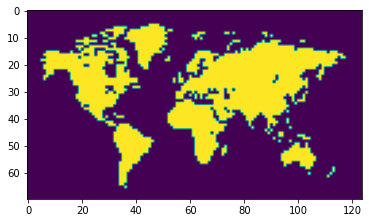

In [238]:
plt.imshow(arr)

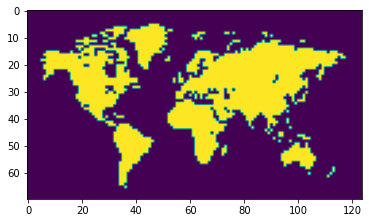

In [239]:
plt.imshow((scores > 0))

254 commands


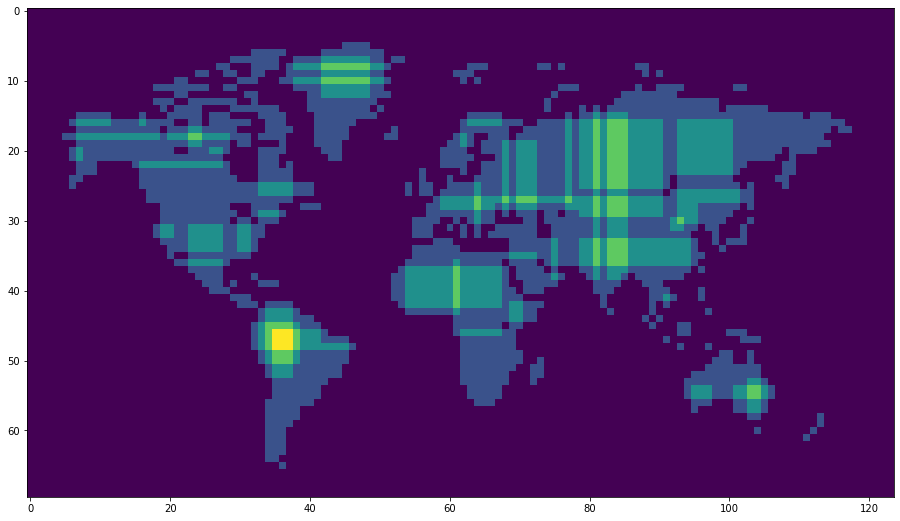

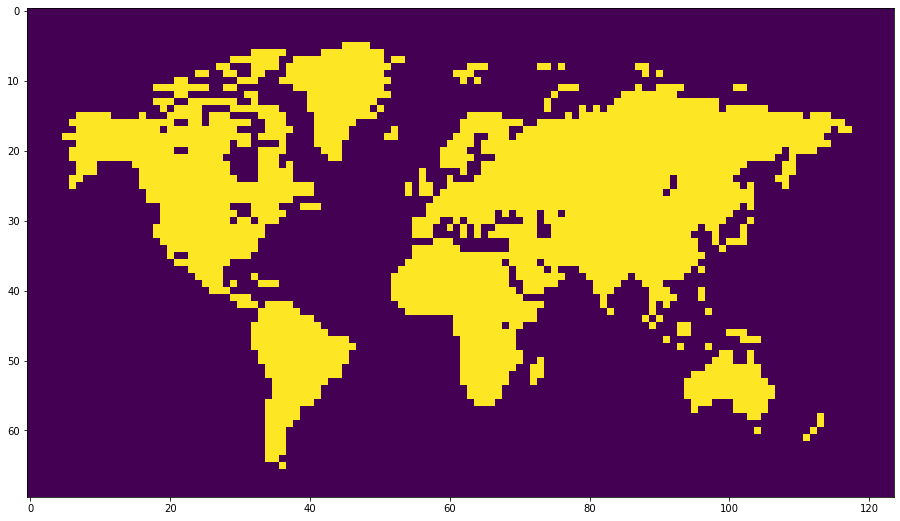

In [307]:
by_step = False
x = 0
canvas = np.zeros(tsrct.shape[:2])

for h, w, i, j in sorted(np.column_stack(tsrct.nonzero()), key=lambda t: (-t[0], -t[1])):
    mem = np.zeros(tsrct.shape[:2])
    mem[i:i + h + 1, j:j + w + 1] += 1

    if by_step:
        plt.figure(figsize = (16, 9))
        plt.imshow(2 * (mem - canvas).clip(min=0) + mem)
        plt.show()

    canvas += mem

    if by_step:
        plt.imshow(canvas)
        plt.show()
        input("Press Enter")
        clear_output()

    x += 1
    
print(x, "commands")
plt.figure(figsize = (16, 9))
plt.imshow(canvas)
plt.show()
plt.figure(figsize = (16, 9))
plt.imshow(canvas > 0)
plt.show()

# Layering Functions

In [6]:
prefix = "summon falling_block ~ ~1 ~ {Time:1,BlockState:{Name:redstone_block},Passengers:[\
{id:armor_stand,Health:0,Passengers:[\
{id:falling_block,Time:1,BlockState:{Name:activator_rail},Passengers:[\
{id:command_block_minecart,Command:'gamerule commandBlockOutput false'},\
{id:command_block_minecart,Command:'data merge block ~ ~-2 ~ {auto:0}'},"

template = "{{id:command_block_minecart,Command:'{0}'}}"

fill_command = "fill {0} {1} {2} {3} {4} {5} {6} {7} {8}"

clone_command = "clone {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10}"

suffix = ",{id:command_block_minecart,Command:'setblock ~ ~1 ~ command_block{auto:1,Command:\"fill ~ ~ ~ ~ ~-2 ~ air\"}'},\
{id:command_block_minecart,Command:'kill @e[type=command_block_minecart,distance=..1]'}]}]}]}"

strings = {
    "prefix": prefix,
    "template": template,
    "fill_command": fill_command,
    "clone_command": clone_command,
    "suffix": suffix
}

In [185]:
def gen_fill(strings, edges, Y, block0, mode=None, block1=None):
    h, w, X0, Z0 = edges
    X1 = X0 + h
    Z1 = Z0 + w
    
    if mode == "keep":
        pass
    elif mode == "replace":
        if block1 is None:
            raise ValueError
    elif mode is None:    
        mode = ""
    else:
        raise ValueError
        
    if block1 is None:
        block1 = ""
    else:
        if mode != "replace":
            raise ValueError
        
    cmd = strings["fill_command"].format(X0, Y, Z0, X1, Y, Z1, block0, mode, block1).strip()
    return strings["template"].format(cmd)
            
def gen_clone(strings, edges, Y0, yShift, mode, block=None):
    h, w, X0, Z0 = edges
    X1 = X0 + h
    Z1 = Z0 + w
    Y1 = Y0 + yShift
    
    if mode == "replace" or mode == "masked":
        pass
    elif mode == "filtered":
        if block is None:
            raise ValueError
    else:
        raise ValueError
        
    if block is None:
        block = ""
    else:
        if mode != "filtered":
            raise ValueError
        
    cmd = strings["clone_command"].format(X0, Y0, Z0, X1, Y0, Z1, X0, Y1, Z0, mode, block).strip()
    return strings["template"].format(cmd)

def package_commands(cmds, strings):
    max_chars = 32500
    prefix = strings["prefix"]
    suffix = strings["suffix"]
    def_len = len(prefix) + len(suffix)
    
    avail_space = max_chars - def_len
    idx = 0
    lens = [len(cmd) + 1 for cmd in cmds]
    batches = []
    
    while lens:
        idx = (np.cumsum(lens) <= avail_space).argmin(0)
        
        if idx == 0:
            idx = len(cmds)
            
        string = prefix + ",".join(cmds[:idx]) + suffix
        batches.append(string)
        lens = lens[idx:]
        cmds = cmds[idx:]
        
    for i, b in enumerate(batches):
        input("Press Enter to store the next command in your clipboard...")
        pc.copy(b)
        print(f"Batch {i + 1} of {len(batches)}")
        
def thicken(multilayer):
    ret = np.zeros(multilayer.shape)
    mem = np.zeros(multilayer.shape[:2])
    
    for z in range(multilayer.shape[2])[::-1]:
        ret[..., z] = multilayer[..., z] + mem
        mem = multilayer[..., z] > 0
        
    return ret
        
def split_layer(layer):
    structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
    labeled, N = label(layer, structure)
    ret = []
    
    # NEED TO FIND "BACKGROUND LABEL" TO EXCLUDE IT
    
    for idx in range(1, N):
        component = (labeled == idx)
        j0, j1 = tuple(np.argwhere(np.any(component, axis=0))[[0, -1]].flatten().tolist())
        i0, i1 = tuple(np.argwhere(np.any(component, axis=1))[[0, -1]].flatten().tolist())
        
        ret.append((i1 - i0, j1 - j0, i0, j0))
        
    return ret
        
def tesselate_layer(layer, h0, w0, i0, j0):
    # Slice out the wanted part
    arr = layer[i0:i0 + h0 + 1, j0:j0 + w0 + 1]
    
    # Initialize working arrays
    tsrct = gen_tesseract_opt(arr)
    mask = gen_tesseract_opt(np.ones(arr.shape), carve=False)
    scores = gen_block_scores_opt(tsrct)
    fills = gen_redundant_fills_opt(tsrct, arr)
    coords_gen = gen_coords_generator(tsrct)
    
    # Iteratively select the best fills
    while select_next_fill_opt(tsrct, scores, fills, coords_gen, mask, arr):
        pass
    
    # Remove redundant fills
    sanitize(tsrct, scores)
    
    # Shrink fills to their minimum useful size
    shrink(tsrct, scores)
    
    return [(h, w, i + i0, j + j0) for h, w, i, j in np.column_stack(tsrct.nonzero()).tolist()]

def cubify(heightmap, Y0, strings):
    multilayer = thicken(heightmap)
    cmds = []
    
    # TEMPORARY, will need world coordinates to shift
    border = heightmap.shape[:2] + (0, 0)
    
    for y in range(heightmap.shape[2]):
        layer = multilayer[..., y]
        sublayers = split_layer(layer)
        edges = []
        
        for (h, w, i, j) in sublayers:
            edges += tesselate_layer(layer, h, w, i, j)
            
        cmds += [gen_fill(strings, elem, Y0 + y, "ice") for elem in edges]
            
        if y != 0:
            cmds.append(gen_clone(strings, border, Y0 + y, -1, "filtered", block="ice"))
            cmds.append(gen_fill(strings, border, Y0 + y - 1, "air", mode="replace", block1="ice"))
        
        cmds.append(gen_fill(strings, border, Y0 + y, "diamond_block", mode="replace", block1="ice"))
    
    package_commands(cmds, strings)

In [186]:
heightmap = np.dstack([big_fish_arr & big_dk_arr & big_world_arr, (1 - big_fish_arr) & big_dk_arr & big_world_arr, (1 - big_fish_arr) & (1 - big_dk_arr) & big_world_arr, (1 - big_fish_arr) & (1 - big_dk_arr) & (1 - big_world_arr) & np.ones(big_world_arr.shape, dtype=bool)])[:, ::-1, :]
heightmap = np.dstack([big_world_arr, (1 - big_world_arr) & np.ones(big_world_arr.shape, dtype=bool)])[:, ::-1, ::-1]
cubify(heightmap, 100, strings)

Press Enter to store the next command in your clipboard... 


Batch 1 of 2


Press Enter to store the next command in your clipboard... 


Batch 2 of 2


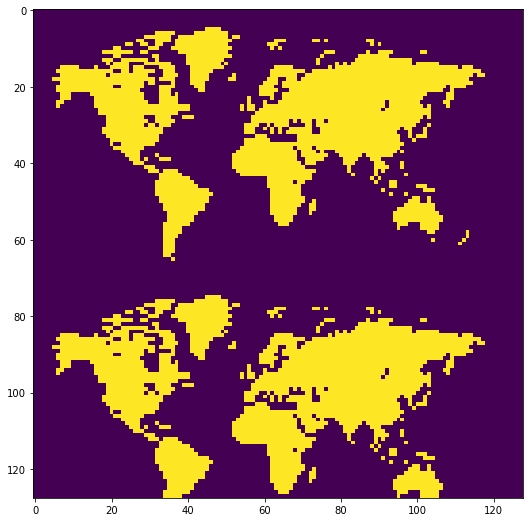

In [163]:
plt.figure(figsize = (16, 9))
plt.imshow(thicken(heightmap)[:, ::-1, 1])
plt.show()

In [164]:
heightmap.shape

(128, 128, 2)

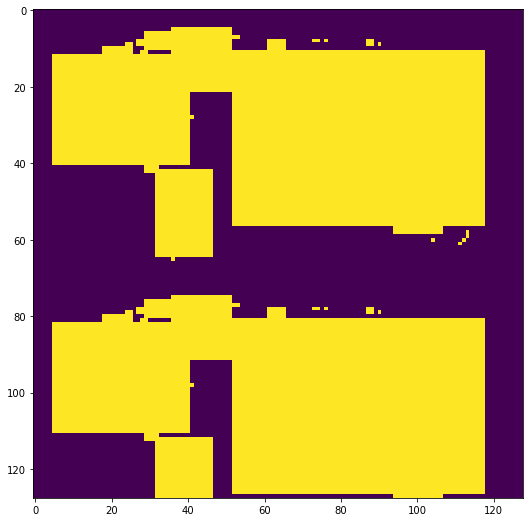

In [183]:
temp = np.zeros(heightmap.shape[:2])

for h, w, i, j in edges:
    temp[i:i+h+1, j:j+w+1] = 1
    
plt.figure(figsize = (16, 9))
plt.imshow(temp[:, ::-1])
plt.show()

In [157]:
n

159

159
5 40 12 40
(29, 36, 12, 5)


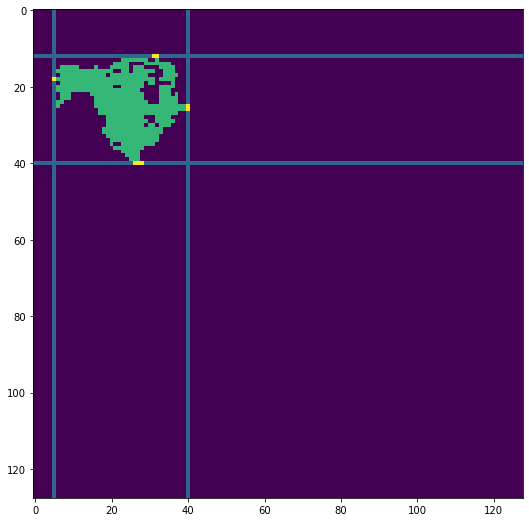

In [144]:
l, n = label(heightmap)
l = l[..., 1]
print(n)

component = (l[:, ::-1] == 20) * 2


structure = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
labeled, N = label(arr, structure)
    #ret = []
    
    #for idx in range(1, N):
     #   component = (labeled == idx)
j0, j1 = tuple(np.argwhere(np.any(component, axis=0))[[0, -1]].flatten().tolist())
i0, i1 = tuple(np.argwhere(np.any(component, axis=1))[[0, -1]].flatten().tolist())
        
       # ret.append((i1 - i0 + 1, j1 - j0 + 1, i0, j0))
        
    #return ret
print(j0, j1, i0, i1)

temp = np.zeros(heightmap.shape[:2], dtype=bool)

temp[i0, :] = 1
temp[i1, :] = 1
temp[:, j0] = 1
temp[:, j1] = 1

print((i1 - i0 + 1, j1 - j0 + 1, i0, j0))

plt.figure(figsize=(16, 9))
plt.imshow(component | temp)
plt.show()

53


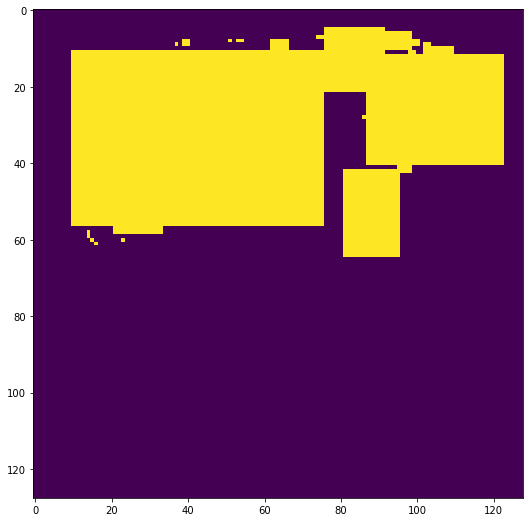

In [156]:
temp = np.zeros(heightmap.shape[:2])

a = 0

for h, w, i, j in split_layer(heightmap[..., 1]):
    a += 1
    temp[i:i+h+1, j:j+w+1] = 1
    
print(a)
    
plt.figure(figsize = (16, 9))
plt.imshow(temp[:, ::-1])
plt.show()



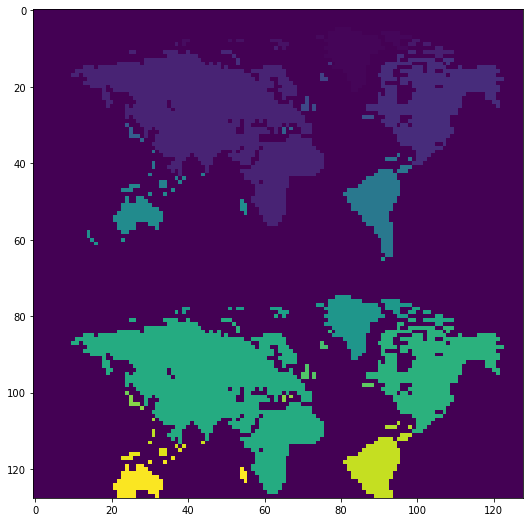

In [158]:
plt.figure(figsize = (16, 9))
plt.imshow(l)
plt.show()

In [170]:

multilayer = thicken(heightmap)
cmds = []
    
    # TEMPORARY, will need world coordinates to shift
border = heightmap.shape[:2] + (0, 0)
    
for y in range(heightmap.shape[2]):
    print(y)
    layer = multilayer[..., y]
    sublayers = split_layer(layer)
    
    print(len(sublayers))

0
53
1
53


In [182]:
len(edges)

102